In [9]:
"""
Particle Filter localization sample
author: Atsushi Sakai (@Atsushi_twi)
"""

import math
import time as t
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from math import sqrt
import pandas as pd

# Estimation parameter of PF
Q = np.diag([0.2]) ** 2  # range error
R = np.diag([2.0, np.deg2rad(40.0)]) ** 2  # input error

#  Simulation parameter
Q_sim = np.diag([0.2]) ** 2
R_sim = np.diag([1.0, np.deg2rad(30.0)]) ** 2

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range

# Particle filter parameter
NP = 100  # Number of Particle
NTh = NP / 2.0  # Number of particle for re-sampling

show_animation = True


def calc_input():
    v = 1.0  # [m/s]
    yaw_rate = 0.1  # [rad/s]
    u = np.array([[v, yaw_rate]]).T
    return u


def observation(x_true, xd, u, rf_id):
    x_true = motion_model(x_true, u)

    # add noise to gps x-y
    z = np.zeros((0, 3))

    for i in range(len(rf_id[:, 0])):

        dx = x_true[0, 0] - rf_id[i, 0]
        dy = x_true[1, 0] - rf_id[i, 1]
        d = math.hypot(dx, dy)
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Q_sim[0, 0] ** 0.5  # add noise
            zi = np.array([[dn, rf_id[i, 0], rf_id[i, 1]]])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * R_sim[0, 0] ** 0.5
    ud2 = u[1, 0] + np.random.randn() * R_sim[1, 1] ** 0.5
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)

    return x_true, z, xd, ud


def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F.dot(x) + B.dot(u)

    return x


def gauss_likelihood(x, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma ** 2) * \
        math.exp(-x ** 2 / (2 * sigma ** 2))

    return p


def calc_covariance(x_est, px, pw):
    """
    calculate covariance matrix
    see ipynb doc
    """
    cov = np.zeros((3, 3))
    n_particle = px.shape[1]
    for i in range(n_particle):
        dx = (px[:, i:i + 1] - x_est)[0:3]
        cov += pw[0, i] * dx @ dx.T
    cov *= 1.0 / (1.0 - pw @ pw.T)

    return cov


def pf_localization(px, pw, z, u, particle_count=NP):
    """
    Localization with Particle filter
    """
    for ip in range(NP):
        x = np.array([px[:, ip]]).T
        w = pw[0, ip]

        #  Predict with random input sampling
        ud1 = u[0, 0] + np.random.randn() * R[0, 0] ** 0.5
        ud2 = u[1, 0] + np.random.randn() * R[1, 1] ** 0.5
        ud = np.array([[ud1, ud2]]).T
        x = motion_model(x, ud)

        #  Calc Importance Weight
        for i in range(len(z[:, 0])):
            dx = x[0, 0] - z[i, 1]
            dy = x[1, 0] - z[i, 2]
            pre_z = math.hypot(dx, dy)
            dz = pre_z - z[i, 0]
            w = w * gauss_likelihood(dz, math.sqrt(Q[0, 0]))

        px[:, ip] = x[:, 0]
        pw[0, ip] = w

    pw = pw / pw.sum()  # normalize

    x_est = px.dot(pw.T)
    p_est = calc_covariance(x_est, px, pw)

    N_eff = 1.0 / (pw.dot(pw.T))[0, 0]  # Effective particle number
    if N_eff < (particle_count / 2.0):
        px, pw = re_sampling(px, pw)
    return x_est, p_est, px, pw


def re_sampling(px, pw, particle_count=NP):
    """
    low variance re-sampling
    """

    w_cum = np.cumsum(pw)
    base = np.arange(0.0, 1.0, 1 / particle_count)
    re_sample_id = base + np.random.uniform(0, 1 / particle_count)
    indexes = []
    ind = 0
    for ip in range(particle_count):
        while re_sample_id[ip] > w_cum[ind]:
            ind += 1
        indexes.append(ind)

    px = px[:, indexes]
    pw = np.zeros((1, particle_count)) + 1.0 / particle_count  # init weight

    return px, pw


def plot_covariance_ellipse(x_est, p_est):  # pragma: no cover
    p_xy = p_est[0:2, 0:2]
    eig_val, eig_vec = np.linalg.eig(p_xy)

    if eig_val[0] >= eig_val[1]:
        big_ind = 0
        small_ind = 1
    else:
        big_ind = 1
        small_ind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)

    # eig_val[big_ind] or eiq_val[small_ind] were occasionally negative
    # numbers extremely close to 0 (~10^-20), catch these cases and set the
    # respective variable to 0
    try:
        a = math.sqrt(eig_val[big_ind])
    except ValueError:
        a = 0

    try:
        b = math.sqrt(eig_val[small_ind])
    except ValueError:
        b = 0

    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eig_vec[1, big_ind], eig_vec[0, big_ind])
    rot = Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]
    fx = rot.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + x_est[0, 0]).flatten()
    py = np.array(fx[1, :] + x_est[1, 0]).flatten()
    plt.plot(px, py, "--r")


def main():
    """
    print('Robot sim initiated!')

    time = 0.0

    # RF_ID positions [x, y]
    rf_id = np.array([[10.0, 0.0],
                      [10.0, 10.0],
                      [0.0, 15.0],
                      [-5.0, 20.0]])

    # State Vector [x y yaw v]'
    x_est = np.zeros((4, 1))
    x_true = np.zeros((4, 1))

    px = np.zeros((4, NP))  # Particle store
    pw = np.zeros((1, NP)) + 1.0 / NP  # Particle weight
    x_dr = np.zeros((4, 1))  # Dead reckoning

    # history
    h_x_est = x_est
    h_x_true = x_true
    h_x_dr = x_true

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        x_true, z, x_dr, ud = observation(x_true, x_dr, u, rf_id)

        x_est, PEst, px, pw = pf_localization(px, pw, z, ud)

        # store data history
        h_x_est = np.hstack((h_x_est, x_est))
        h_x_dr = np.hstack((h_x_dr, x_dr))
        h_x_true = np.hstack((h_x_true, x_true))

    plt.cla()
    for i in range(len(z[:, 0])):
        plt.plot([x_true[0, 0], z[i, 1]], [x_true[1, 0], z[i, 2]], "-k")
    plt.plot(rf_id[:, 0], rf_id[:, 1], "*k")
    plt.plot(px[0, :], px[1, :], ".r")
    plt.plot(np.array(h_x_true[0, :]).flatten(),
                np.array(h_x_true[1, :]).flatten(), "-b")
    plt.plot(np.array(h_x_dr[0, :]).flatten(),
                np.array(h_x_dr[1, :]).flatten(), "-k")
    plt.plot(np.array(h_x_est[0, :]).flatten(),
                np.array(h_x_est[1, :]).flatten(), "-r")
    plot_covariance_ellipse(x_est, PEst)
    plt.axis("equal")
    plt.grid(True)
    """
    pass



In [3]:
def runSimulation():
    # print('Robot sim initiated!')

    time = 0.0

    # RF_ID positions [x, y]
    rf_id = np.array([[10.0, 0.0],
                      [10.0, 10.0],
                      [0.0, 15.0],
                      [-5.0, 20.0]])

    # State Vector [x y yaw v]'
    x_est = np.zeros((4, 1))
    x_true = np.zeros((4, 1))

    px = np.zeros((4, NP))  # Particle store
    pw = np.zeros((1, NP)) + 1.0 / NP  # Particle weight
    x_dr = np.zeros((4, 1))  # Dead reckoning

    # history
    h_x_est = x_est
    h_x_true = x_true
    h_x_dr = x_true

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        x_true, z, x_dr, ud = observation(x_true, x_dr, u, rf_id)

        x_est, PEst, px, pw = pf_localization(px, pw, z, ud)

        # store data history
        h_x_est = np.hstack((h_x_est, x_est))
        h_x_dr = np.hstack((h_x_dr, x_dr))
        h_x_true = np.hstack((h_x_true, x_true))

        """
        for i in range(len(z[:, 0])):
            plt.plot([x_true[0, 0], z[i, 1]], [x_true[1, 0], z[i, 2]], "-k")
        plt.plot(rf_id[:, 0], rf_id[:, 1], "*k")
        # plt.plot(px[0, :], px[1, :], ".r")
        plt.plot(np.array(h_x_true[0, :]).flatten(),
                    np.array(h_x_true[1, :]).flatten(), "-b")
        plt.plot(np.array(h_x_dr[0, :]).flatten(),
                    np.array(h_x_dr[1, :]).flatten(), "-k")
        plt.plot(np.array(h_x_est[0, :]).flatten(),
                    np.array(h_x_est[1, :]).flatten(), "-r")
        plot_covariance_ellipse(x_est, PEst)
        plt.axis("equal")
        plt.grid(True)

        plt.savefig(f'{math.ceil(time * 1/0.1)}.jpeg')
        """

    # print('PF MSE: ', mse(h_x_true.T[:, :2], h_x_est.T[:, :2]))
    # print('PF RMSE: ', math.sqrt(mse(h_x_true.T[:, :2], h_x_est.T[:, :2])))
    # print('R2 MEASURE: ', r2(h_x_true.T[:, :2], h_x_est.T[:, :2]))

    return h_x_est, h_x_true, h_x_dr

In [7]:
pf_mse_array = []
pf_rmse_array = []
pf_r2_array = []

print('Calculating 25 PF...')
for i in range(25):
    pf_hxpred, pf_hxtrue, pf_hxdr = runSimulation()
    pf_mse_array += [
        (
            mse(pf_hxtrue.T[:, :2], pf_hxdr.T[:, :2]),
            mse(pf_hxtrue.T[:, :2], pf_hxpred.T[:, :2])
        )
    ]
    pf_rmse_array += [
        (
            sqrt(mse(pf_hxtrue.T[:, :2], pf_hxdr.T[:, :2])),
            sqrt(mse(pf_hxtrue.T[:, :2], pf_hxpred.T[:, :2]))
        )
    ]
    pf_r2_array += [
        (
            r2(pf_hxtrue.T[:, :2], pf_hxdr.T[:, :2]),
            r2(pf_hxtrue.T[:, :2], pf_hxpred.T[:, :2])
        )
    ]
print('Done!')

Calculating 25 PF...


In [ ]:
# times = []
# Time simulation
# for particle_count in [100, 500, 1000, 2500, 5000]:
# startTime = t.time()
# runSimulation()
# endTime = t.time()
# times += [endTime - startTime]

Robot sim initiated!
PF MSE:  0.011529273247454386
PF RMSE:  0.10737445342098086
R2 MEASURE:  0.9997528589241816


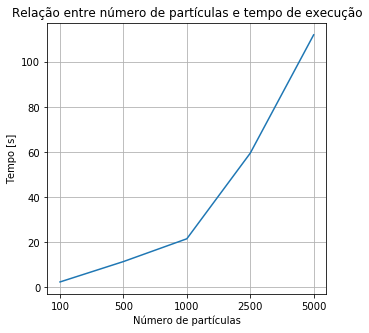

In [ ]:
# # Plot times
# times = [
#     2.454495668411255,
#     11.48201584815979,
#     21.576645374298096,
#     59.50371861457825,
#     111.92827582359314
# ]
# plt.figure(figsize=(5, 5))
# plt.title("Relação entre número de partículas e tempo de execução")
# plt.plot(['100', '500', '1000', '2500', '5000'], times)
# plt.xlabel("Número de partículas")
# plt.ylabel("Tempo [s]")
# plt.grid(True)
# plt.show()

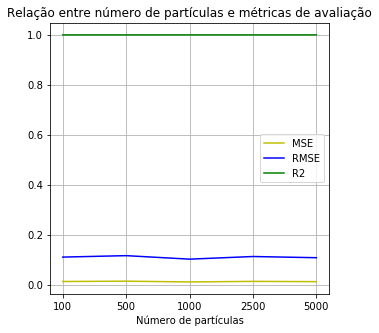

In [ ]:
# Plot metrics
# msqe = [
#     0.012062684086272625,
#     0.01336926557614474,
#     0.010324204655514521,
#     0.012579798826597767,
#     0.011529273247454386
# ]

# rmsqe = [
#     0.10983025123467863,
#     0.11562554032801205,
#     0.10160809345477613,
#     0.1121597023293026,
#     0.10737445342098086
# ]

# r2measure = [
#     0.999745404275268,
#     0.9997139401683748,
#     0.9997789109240718,
#     0.9997326673082871,
#     0.9997528589241816
# ]

# plt.figure(figsize=(5, 5))
# plt.title("Relação entre número de partículas e métricas de avaliação")
# plt.plot(['100', '500', '1000', '2500', '5000'], msqe, '-y', label='MSE')
# plt.plot(['100', '500', '1000', '2500', '5000'], rmsqe, '-b', label='RMSE')
# plt.plot(['100', '500', '1000', '2500', '5000'], r2measure, '-g', label='R2')
# plt.xlabel("Número de partículas")
# plt.grid(True)
# plt.legend()
# plt.show()

In [17]:
mse_df = pd.DataFrame(pf_mse_array).rename(columns={0: 'DR', 1:'PF'}).describe().iloc[1:3, :]
rmse_df = pd.DataFrame(pf_rmse_array).rename(columns={0: 'DR', 1:'PF'}).describe().iloc[1:3, :]
r2_df = pd.DataFrame(pf_r2_array).rename(columns={0: 'DR', 1:'PF'}).describe().iloc[1:3, :]

In [23]:
mse_df = mse_df.T.rename(columns={'mean':'mse_mean', 'std':'mse_std'})

In [24]:
rmse_df = rmse_df.T.rename(columns={'mean':'rmse_mean', 'std':'rmse_std'})

In [25]:
r2_df = r2_df.T.rename(columns={'mean':'r2_mean', 'std':'r2_std'})

In [30]:
metrics = pd.concat([mse_df, rmse_df, r2_df], axis=1)

In [31]:
metrics

,mse_mean,mse_std,rmse_mean,rmse_std,r2_mean,r2_std
DR,50.883571,71.094227,6.100140,3.773794,-0.083387,1.478377
PF,0.013390,0.001474,0.115547,0.006346,0.999714,0.000032
